[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [132]:
pip install statsmodels yfinance pmdarima arch

     |████████████████████████████████| 592 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 873 kB 10.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [246]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 1
# plt.style.use('.matplotlibrc')

In [76]:
from datetime import datetime
import yfinance as yf
  
start_date = datetime(2005, 1, 1)
end_date = datetime(2021, 1, 1)

df = yf.download(
    'SPY',
    start=start_date,
    end = end_date
)

[*********************100%***********************]  1 of 1 completed


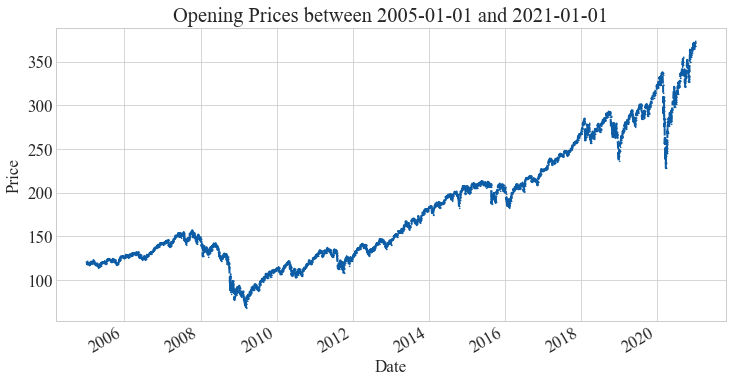

In [247]:
plt.figure(figsize = (12, 6))
plt.title('Opening Prices between {} and {}'.format(
    start_date.date().isoformat(),
    end_date.date().isoformat()
))
df['Open'].plot()
plt.ylabel('Price')
plt.xlabel('Date');

In [89]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,121.559998,121.760002,119.900002,120.300003,86.852043,55748000
2005-01-04,120.459999,120.540001,118.440002,118.830002,85.790764,69167600
2005-01-05,118.739998,119.250000,118.000000,118.010002,85.198761,65667300
2005-01-06,118.440002,119.150002,118.260002,118.610001,85.631920,47814700
2005-01-07,118.970001,119.230003,118.129997,118.440002,85.509186,55847700


In [92]:
df1 = df.reset_index().resample('W', on="Date")['Open'].mean()

In [99]:
# some years have 53 weeks. We can't handle that, so we'll get rid of the 53rd week.
df1 = df1[df1.index.week < 53]

<ipython-input-99-4291efa8995c>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df1 = df1[df1.index.week < 53]


<ipython-input-248-18f224039591>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df1.index.week.value_counts().plot.bar()


<AxesSubplot:>

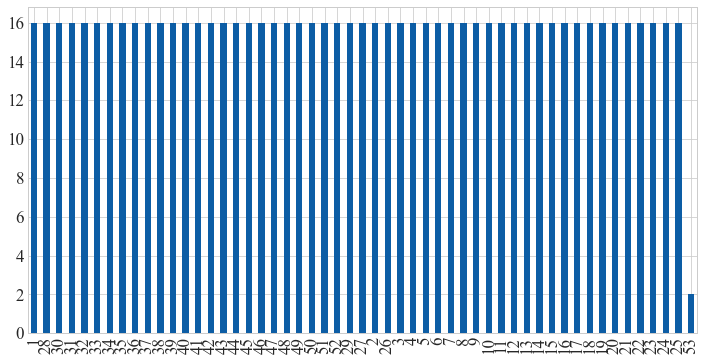

In [248]:
# final check: 
df1.index.week.value_counts().plot.bar()

In [270]:
df1 = df1[~df1.isnull()]

In [276]:
# let's fix the frequency:
df1 = df1.asfreq('W').fillna(method='ffill')

In [277]:
df1.index.freq

<Week: weekday=6>

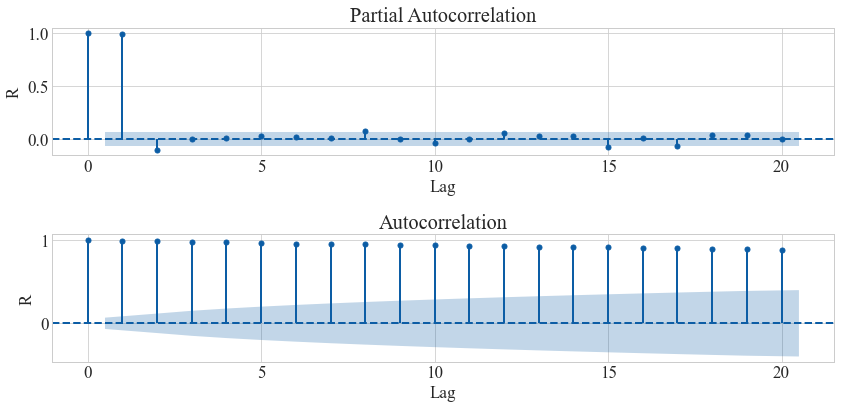

In [279]:
import statsmodels.api as sm

fig, axs = plt.subplots(2)
sm.graphics.tsa.plot_pacf(df1, lags=20, ax=axs[0])
axs[0].set_ylabel('R')
axs[0].set_xlabel('Lag')
sm.graphics.tsa.plot_acf(df1, lags=20, ax=axs[1]);
axs[1].set_ylabel('R')
axs[1].set_xlabel('Lag')
fig.tight_layout()

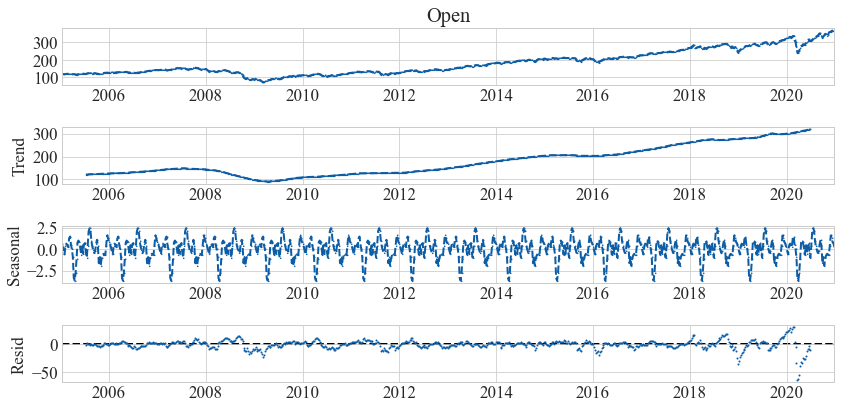

In [280]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df1, model='additive', period=52)
result.plot();

# Finding a value for d

We are using the ARCH package which has more convenient versions of both the ADF and the KPSS tests.

In [281]:
from arch.unitroot import KPSS, ADF

ADF(df1)

Test Statistic,1.325
P-value,0.997
Lags,9


In [282]:
from pmdarima.arima.utils import ndiffs

# ADF Test:
ndiffs(df1, test='adf')  # 1; same values for the KPSS and the PP test

1

In [283]:
# what happens if we forget differencing?
# We get a helful warning: 'Non-stationary starting autoregressive parameters'
mod = sm.tsa.arima.ARIMA(endog=df1, order=(1, 0, 0))
res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  834
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2257.821
Date:                Sun, 22 Aug 2021   AIC                           4521.642
Time:                        16:52:56   BIC                           4535.821
Sample:                    01-09-2005   HQIC                          4527.078
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        182.3710    319.305      0.571      0.568    -443.456     808.198
ar.L1          0.9996      0.002    632.859      0.000       0.996       1.003
sigma2        13.0418      0.218     59.826      0.0

In [311]:
# let's try again and this time, we'll take into account the seasonality:
from statsmodels.tsa.forecasting.stl import STLForecast

mod = STLForecast(df1, sm.tsa.arima.ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))
res = mod.fit().model_result
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  834
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1965.555
Date:                Sun, 22 Aug 2021   AIC                           3937.110
Time:                        17:09:01   BIC                           3951.285
Sample:                    01-09-2005   HQIC                          3942.545
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2771      0.119      2.327      0.020       0.044       0.511
ar.L1          0.2502      0.022     11.402      0.000       0.207       0.293
sigma2         6.5618      0.184     35.641      0.0

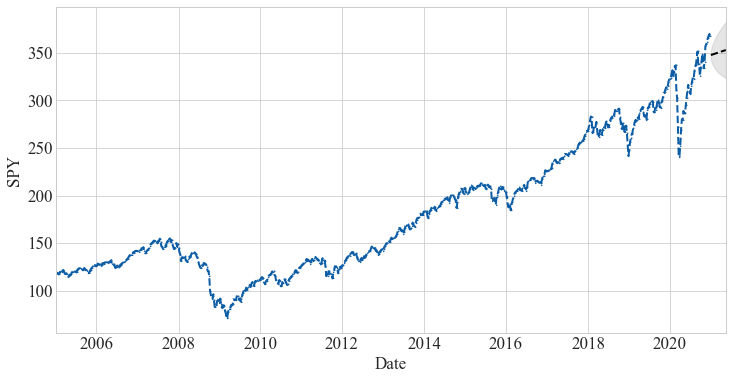

In [312]:
# doing a forecast:
STEPS = 20
forecasts_df = res.get_forecast(steps=STEPS).summary_frame() 
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts_df['mean'].plot(style='k--')
ax.fill_between(
    forecasts_df.index,
    forecasts_df['mean_ci_lower'],
    forecasts_df['mean_ci_upper'],
    color='k',
    alpha=0.1
)

In [303]:
forecasts = []
qs = []
for q in range(0, 30, 10):
    mod = STLForecast(df1, sm.tsa.arima.ARIMA, model_kwargs=dict(order=(0, 1, q), trend="t"))
    res = mod.fit().model_result
    print(f"aic ({q}): {res.aic}")
    forecasts.append(
            res.get_forecast(steps=STEPS).summary_frame()['mean']
        )
    qs.append(q)

forecasts_df = pd.concat(forecasts, axis=1)
forecasts_df.columns = qs

aic (0): 3989.0104184919096
aic (10): 3934.375909262983
aic (20): 3935.3355340835


<AxesSubplot:xlabel='Date', ylabel='SPY'>

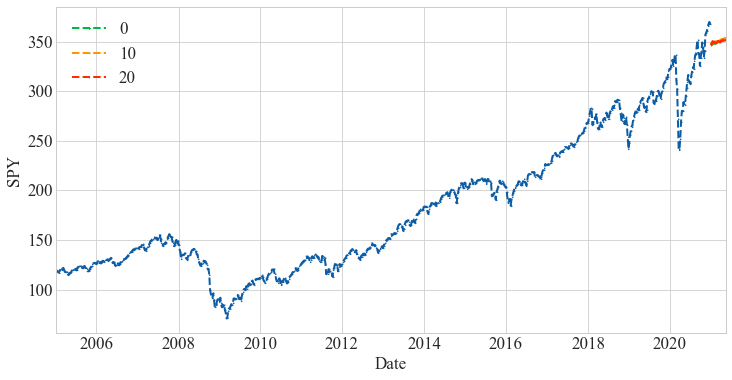

In [305]:
# plotting the three forecasts:
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts_df.plot(ax=ax)

In [313]:
mod = sm.tsa.ExponentialSmoothing(
        endog=df1, trend='add', seasonal_periods=52, use_boxcox=True, initialization_method="heuristic"
    )
res = mod.fit()
print(res.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                     Open   No. Observations:                  834
Model:             ExponentialSmoothing   SSE                          10769.528
Optimized:                         True   AIC                           2141.574
Trend:                         Additive   BIC                           2160.479
Seasonal:                          None   AICC                          2141.676
Seasonal Periods:                  None   Date:                 Sun, 22 Aug 2021
Box-Cox:                           True   Time:                         17:13:45
Box-Cox Coeff.:                -0.29854                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend             0.0000

<AxesSubplot:xlabel='Date', ylabel='SPY'>

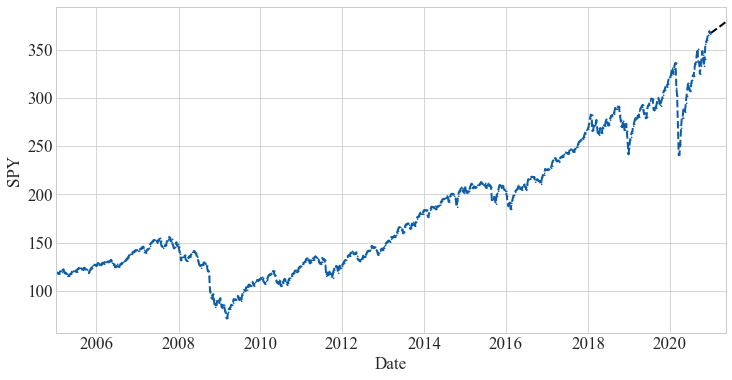

In [314]:
forecasts = pd.Series(res.forecast(steps=STEPS))
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts.plot(style='k--')

<AxesSubplot:xlabel='Date', ylabel='SPY'>

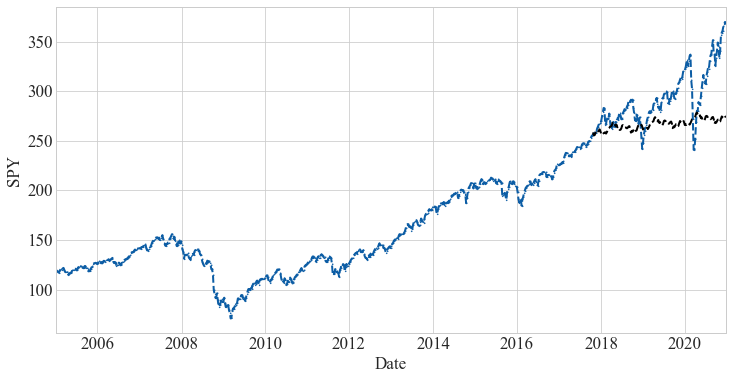

In [329]:
from statsmodels.tsa.forecasting.theta import ThetaModel

train_length = int(len(df1) * 0.8)
tm = ThetaModel(df1[:train_length], method="auto", deseasonalize=True)
res = tm.fit()
forecasts = reds.forecast(steps=len(df1)-train_length)
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts.plot(style='k--')

In [333]:
from sklearn import metrics

metrics.mean_squared_error(forecasts, df1[train_length:], squared=False)

37.06611385754943